**São Gonçalo - RJ**

In [4]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

In [5]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [6]:
city = 'São Gonçalo'
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [7]:
len(df)

12165

In [8]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:59:10,user_location,Rio de Janeiro,São Gonçalo,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt
1,2020-02-02 14:17:20,user_location,Rio de Janeiro,São Gonçalo,A pessoa escreveu sobre uma situação envolvend...,0.0000,pt
2,2020-02-02 18:33:18,user_location,Rio de Janeiro,São Gonçalo,"""Coronavirus não sobrevive a temperaturas a pa...",0.0000,pt
3,2020-02-02 19:41:21,user_location,Rio de Janeiro,São Gonçalo,"RT @SG_vai_mudar: ""Coronavirus não sobrevive a...",0.0000,pt
4,2020-02-02 20:24:09,user_location,Rio de Janeiro,São Gonçalo,Precaução! Coronavírus faz Rio preparar plano ...,-0.4199,pt


Média total de sentimentos - Vader

In [9]:
df['score'].describe()

count    12165.000000
mean        -0.030113
std          0.438542
min         -0.997000
25%         -0.361200
50%          0.000000
75%          0.276900
max          0.998900
Name: score, dtype: float64

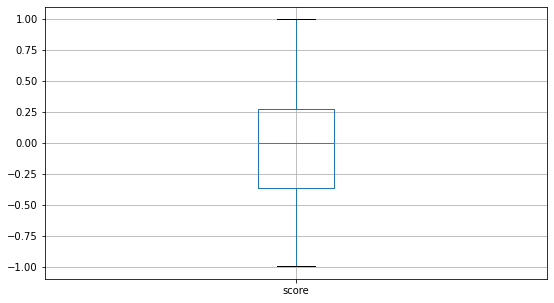

In [10]:
boxplot = df.boxplot(column=['score'], grid=True, figsize=(9, 5))

Média de sentimentos por dia - Vader x SenticNet

Análises por período

In [11]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [12]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city = df_cases_city.drop(columns=['index'])
df_cases_city.head()

,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,São Gonçalo,2020-03-23,3,0.27479,0.0,0,RJ,3,0
1,São Gonçalo,2020-03-24,3,0.27479,0.0,0,RJ,0,0
2,São Gonçalo,2020-03-25,3,0.27479,0.0,0,RJ,0,0
3,São Gonçalo,2020-03-26,3,0.27479,0.0,0,RJ,0,0
4,São Gonçalo,2020-03-27,4,0.36639,0.0,0,RJ,1,0


In [13]:
# Data do início das medidas restritivas
restriction_date = '2020-03-20'
print(restriction_date)

2020-03-20


In [14]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-23


In [15]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-04-01


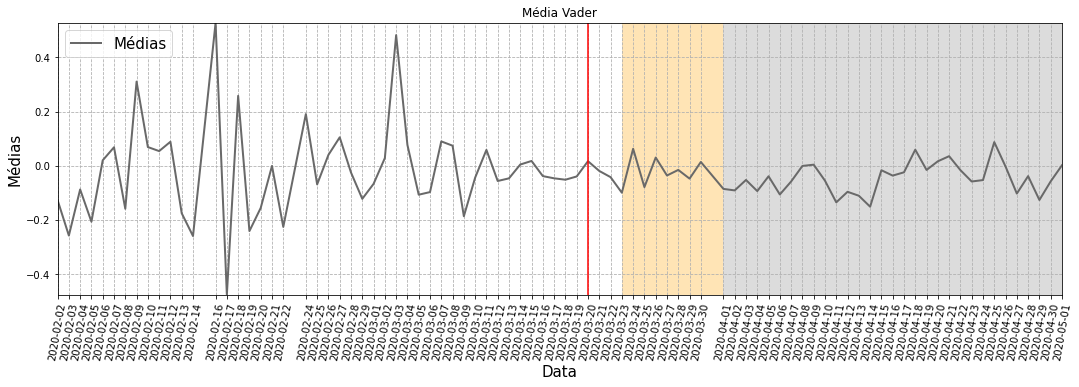

In [39]:
df_scores_city = fresults.building_dates_df(df, 'score')

x = df_scores_city.created_at
y = df_scores_city.score_mean

color = 'dimgrey'

label = 'Médias'
xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader'

fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, restriction_date, first_case_date, first_death_date)

**Análises por Período - Geral**

In [17]:
df_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_date+' 00:00:00"')
print(len(df_periodo1))

df_periodo2 = df.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
print(len(df_periodo2))

df_periodo3 = df.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
print(len(df_periodo3))

4810
1259
6096


In [18]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

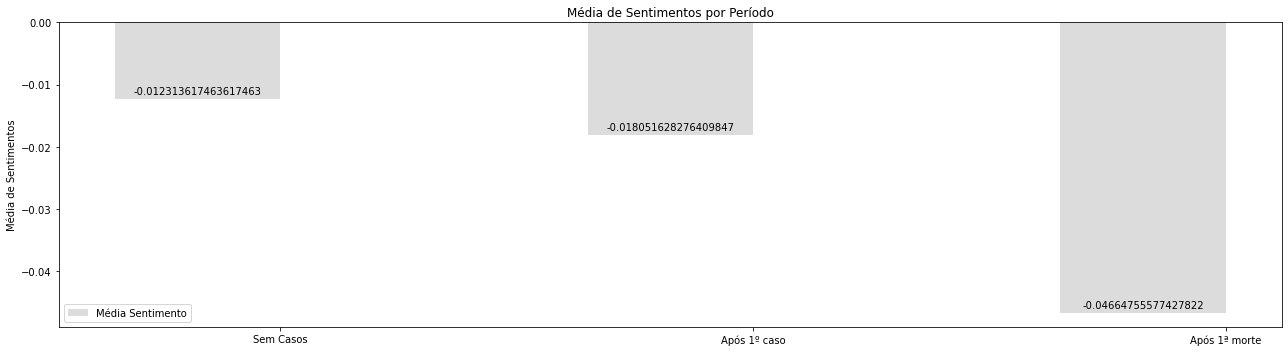

In [19]:
labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df_periodo1['score']), mean(df_periodo2['score']), mean(df_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

***
**Análises por Período - Detalhado**

**Tweets Negativos**

In [20]:
start = df['score'].describe()['min']
end = df['score'].describe()['25%']

print(start,end)

-0.997 -0.3612


Nuvem de palavras dos tweets mais negativos

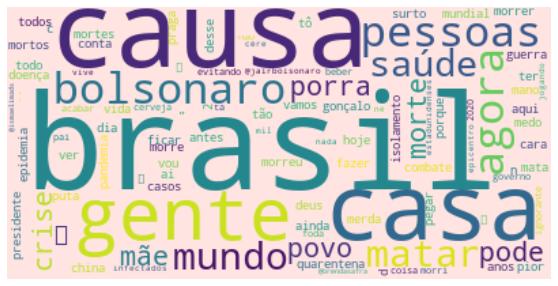

In [21]:
tokens_neg = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_neg, 'mistyrose')

Palavras presentes nos tweets que mais influenciaram negativamente

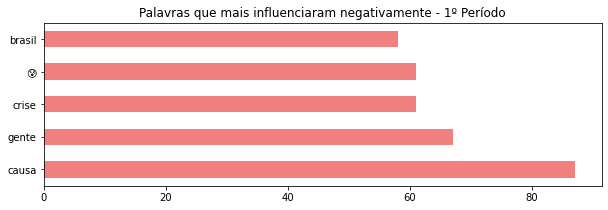

In [22]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_neg_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_neg_1, 5, 'lightcoral', 10, 3, title)

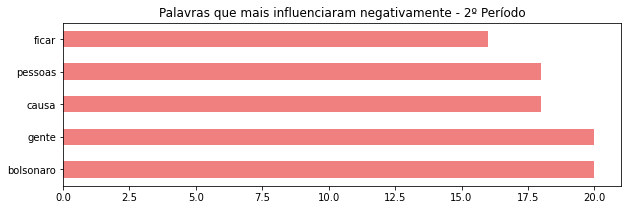

In [23]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_neg_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_neg_2, 5, 'lightcoral', 10, 3, title)

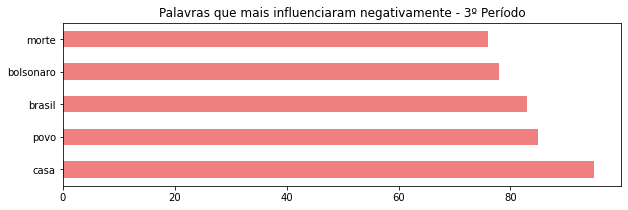

In [24]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_neg_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_neg_3, 5, 'lightcoral', 10, 3, title)

Hashtags que mais influenciaram negativamente

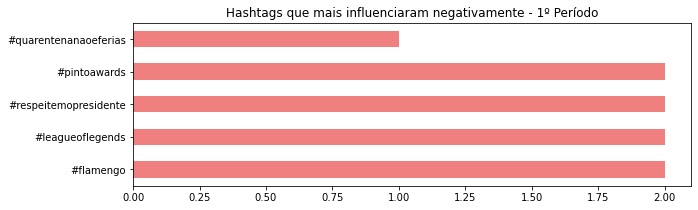

In [25]:
title = 'Hashtags que mais influenciaram negativamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_1, 5, '#', 'lightcoral', 10, 3, title)

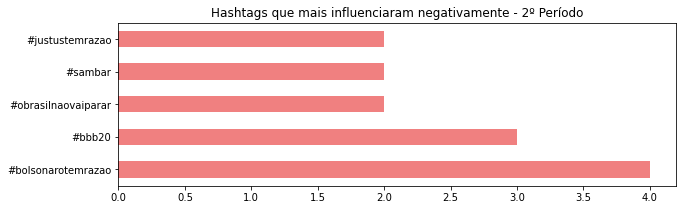

In [26]:
title = 'Hashtags que mais influenciaram negativamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_2, 5, '#', 'lightcoral', 10, 3, title)

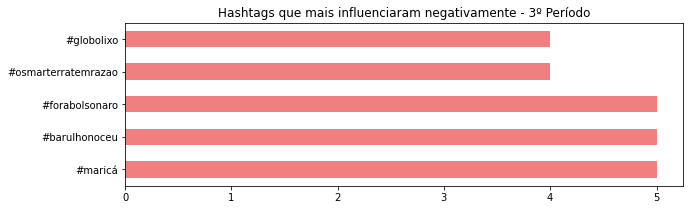

In [27]:
title = 'Hashtags que mais influenciaram negativamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_3, 5, '#', 'lightcoral', 10, 3, title)

**Tweets Positivos**

In [28]:
start = df['score'].describe()['75%']
end = df['score'].describe()['max']

print(start,end)

0.2769 0.9989


Nuvens de palavras que influenciaram positivamente

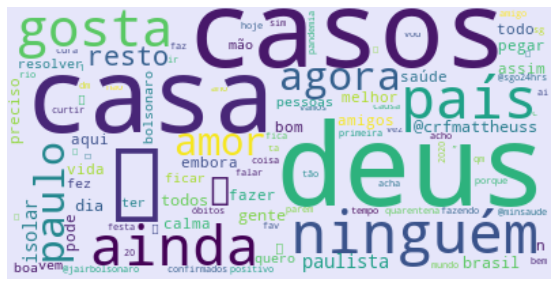

In [29]:
tokens_pos = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_pos, 'lavender')

Palavras presentes nos tweets que mais influenciaram positivamente

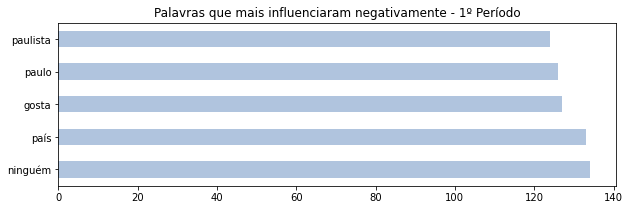

In [30]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_pos_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_pos_1, 5, 'lightsteelblue', 10, 3, title)

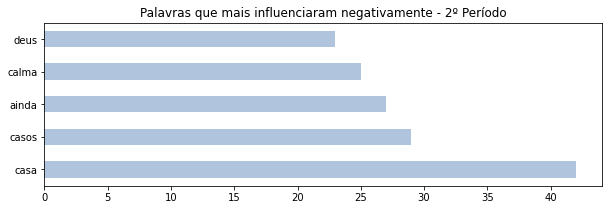

In [31]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_pos_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_pos_2, 5, 'lightsteelblue', 10, 3, title)

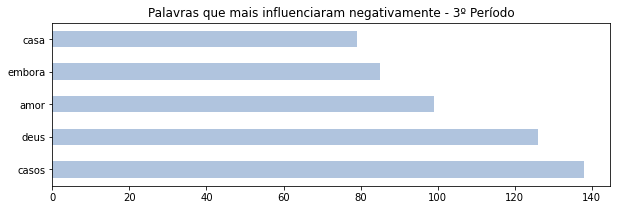

In [32]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_pos_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_pos_3, 5, 'lightsteelblue', 10, 3, title)

Hashtags que mais influenciaram positivamente

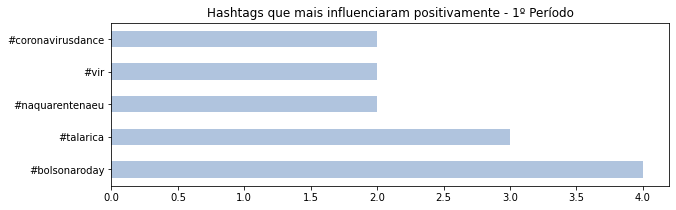

In [33]:
title = 'Hashtags que mais influenciaram positivamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_1, 5, '#', 'lightsteelblue', 10, 3, title)

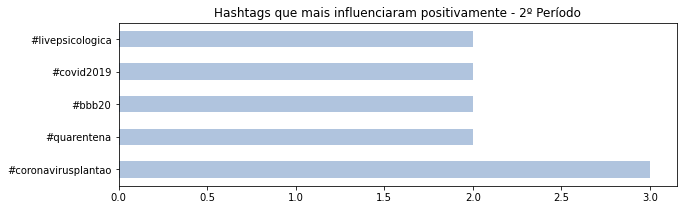

In [34]:
title = 'Hashtags que mais influenciaram positivamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_2, 5, '#', 'lightsteelblue', 10, 3, title)

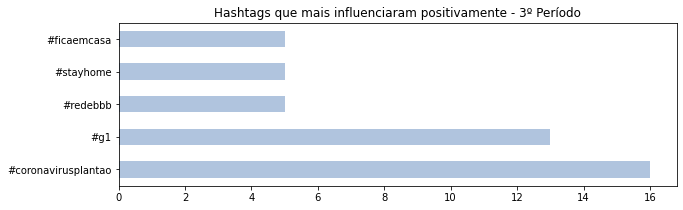

In [35]:
title = 'Hashtags que mais influenciaram positivamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_3, 5, '#', 'lightsteelblue', 10, 3, title)

***
Correlações com Casos de Covid

In [36]:
df_cases_city_2 = df_cases_city.query('date >= "'+first_case_date+'" and date < "'+first_death_date+'"')
df_cases_city_3 = df_cases_city.query('date >= "'+first_death_date+'" and date < "2020-05-02"')

df_scores_city_2 = df_scores_city.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
df_scores_city_3 = df_scores_city.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

df_prepared_2 = fresults.prepare_data(df_cases_city_2, df_scores_city_2)
df_prepared_3 = fresults.prepare_data(df_cases_city_3, df_scores_city_3)

In [37]:
target_column = 'score_mean'
corr_matrix = df_prepared_2.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                       1.000000
last_available_confirmed_per_100k_inhabitants    0.089262
last_bad_news                                    0.089261
last_available_confirmed                         0.089261
last_bad_news_pct                               -0.161711
Name: score_mean, dtype: float64

In [38]:
target_column = 'score_mean'
corr_matrix = df_prepared_3.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                       1.000000
last_available_confirmed_per_100k_inhabitants    0.178777
last_available_confirmed                         0.178777
last_bad_news                                    0.178236
last_available_deaths                            0.165615
Name: score_mean, dtype: float64